In [366]:
import tifffile

import cv2
from skimage.io import *
import skimage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import re
from os.path import join, exists, basename
from os import listdir, makedirs

%matplotlib inline

In [25]:
def convert_labels_to_correct_csv(inpath, outpath):
    with open(inpath, 'r') as fin, open(outpath, 'w') as fout:
        fin.readline()   # skip first line
        fout.write('ImageId;BuildingId;PolygonWKT_Pix;PolygonWKT_Geo' + '\n')
        
        for line in fin:
            img_building = line.split('"')[1][:-1]
            img_building_new = img_building.replace(',', ';')
            line = line.replace(img_building, img_building_new)
            line = line.replace(',""', ';')
            line = line.replace('"', '')
            fout.write(line + '\n')

In [26]:
convert_labels_to_correct_csv(inpath = 'data/testset/summaryData/Test_Set.csv',
                              outpath = 'data/testset/summaryData/Test_Set1.csv')

In [19]:
test_labels = pd.read_csv('data/testset/summaryData/Test_Set1.csv', sep=';')

In [20]:
test_labels.shape

(3597, 4)

In [27]:
test_labels.head(3)

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo
0,img1003,1,"POLYGON ((269.45 617.18 0,174.02 602.62 0,163....",POLYGON ((2.264358925000067 48.993389511000032...
1,img1003,2,"POLYGON ((156.06 610.59 0,92.06 600.0 0,81.06 ...",POLYGON ((2.264052757000059 48.993407310000066...
2,img1003,3,"POLYGON ((43.46 593.21 0,-0.0 585.81 0,-0.0 64...",POLYGON ((2.263748737000071 48.993454224000061...


In [203]:
def read_rgb_pan_as_gray(img_path):
    img = skimage.io.imread(img_path)
    
    img_norm = (img - img.min()) / (img.max() - img.min())
    img_norm = (img_norm * 255.).astype('uint8')

    img_yuv = cv2.cvtColor(img_norm, cv2.COLOR_RGB2YUV)
    img_out = cv2.equalizeHist(img_yuv[:,:,0])
    
    return img_out

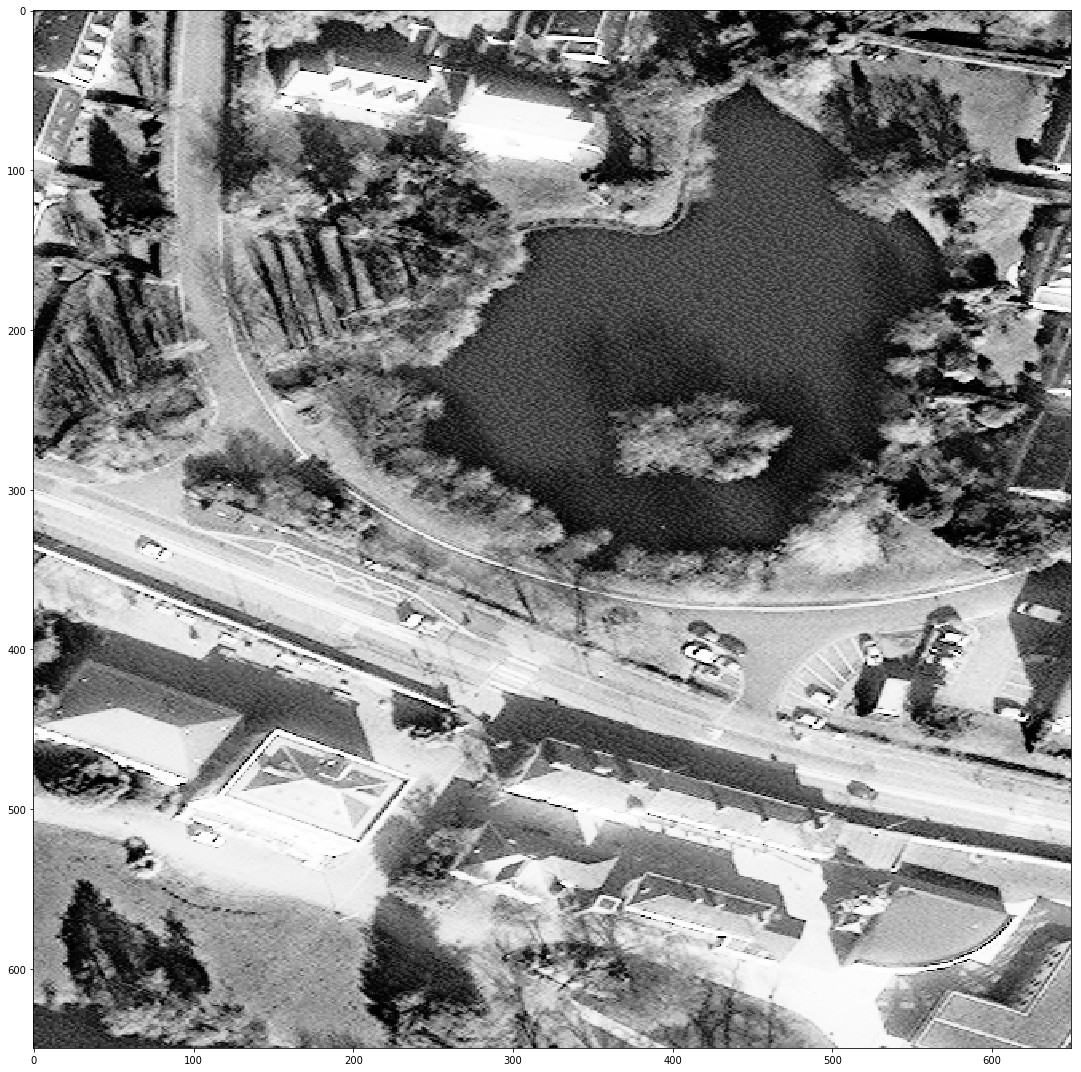

In [204]:
plt.figure(figsize=(15, 15))
imshow(read_rgb_pan_as_gray('data/testset/RGB-PanSharpen/img1506.tif'))
# imshow(img_output)

In [361]:
def draw_building_masks(img, img_id, labels):
    poly_strs = list(labels[labels['ImageId'] == img_id]['PolygonWKT_Pix'])

    contours = []

    for poly_str in poly_strs:
        points_str = re.findall('\d+\.*\d+ \d+\.*\d+', poly_str)
        points = list(map(lambda p_str: [[round(float(p_s)) for p_s in p_str.split(' ')]], points_str))

        contour = np.array(points, dtype=np.int)
        contours.append(contour)

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask_poly = cv2.drawContours(mask, contours, -1, 255, -1)
    
    return mask_poly

In [362]:
mask_poly = draw_building_masks(img, img_name, test_labels)

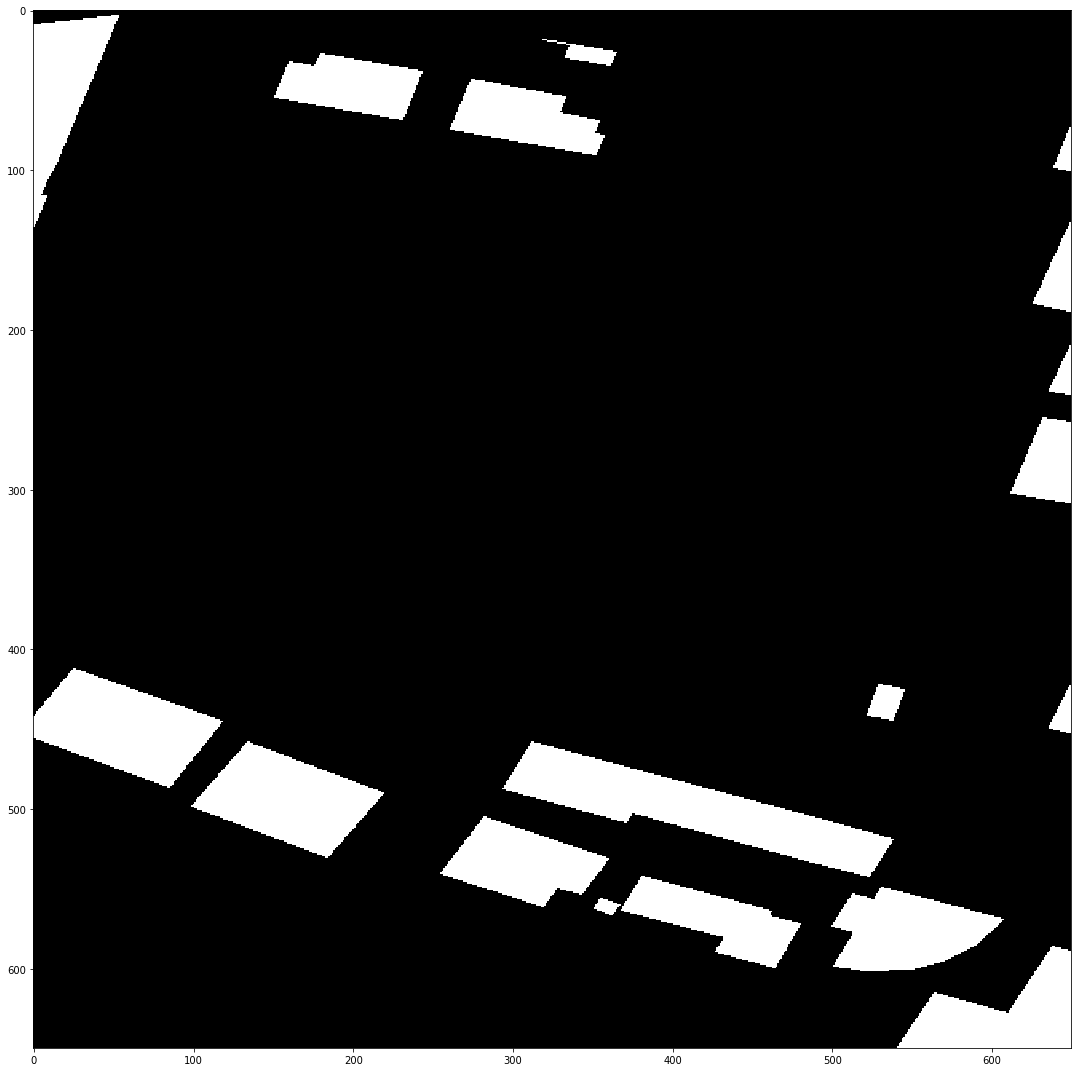

In [363]:
plt.figure(figsize=(15, 15))
imshow(mask_poly)

In [369]:
def extract_images_and_masks(img_dir_pattern, img_out_dir, mask_out_dir, labels):
    if not exists(img_out_dir):
        makedirs(img_out_dir)
    img_path_pattern = join(img_out_dir, '{}.png')

    if not exists(mask_out_dir):
        makedirs(mask_out_dir)
    mask_path_pattern = join(mask_out_dir, '{}.png')

    img_ids = np.unique(labels['ImageId'])

    for img_id in tqdm(img_ids):
        img_path = img_dir_pattern.format(img_id)
        img = read_rgb_pan_as_gray(img_path)
        mask_poly = draw_building_masks(img, img_id, labels)

        cv2.imwrite(img_path_pattern.format(img_id), img)
        cv2.imwrite(mask_path_pattern.format(img_id), mask_poly)

In [370]:
extract_images_and_masks(img_dir_pattern='data/testset/RGB-PanSharpen/{}.tif',
                         img_out_dir='data/test/images',
                         mask_out_dir='data/test/masks',
                         labels=test_labels)

100%|██████████| 129/129 [00:04<00:00, 27.59it/s]


In [372]:
convert_labels_to_correct_csv(inpath = 'data/trainset/summaryData/Train_Set.csv',
                              outpath = 'data/trainset/summaryData/Train_Set1.csv')
train_labels = pd.read_csv('data/trainset/summaryData/Train_Set1.csv', sep=';')

In [373]:
train_labels.shape

(13036, 4)

In [374]:
extract_images_and_masks(img_dir_pattern='data/trainset/RGB-PanSharpen/{}.tif',
                         img_out_dir='data/train/images',
                         mask_out_dir='data/train/masks',
                         labels=train_labels)

100%|██████████| 504/504 [00:17<00:00, 28.71it/s]
